# Cells deconvolution with GraphST

In this notebook, we performed cell deconvolution with GraphST on lymph nodes datasat (public dataset)

# 0. Installation

#create an environment called GraphST

conda create -n GraphST python=3.8

#activate your environment

conda activate GraphST

#install package

pip install GraphST

#To use the environment in jupyter notebook, add python kernel for this environment.

pip install ipykernel

python -m ipykernel install --user --name=GraphST

pip install --user scikit-misc

Restart the kernel then change the kernel in : Kernel -> Change Kernel -> GraphST

pip install scanpy

pip install POT

pip install torch

## 1. Import packages and data

In [1]:
import os
import scanpy as sc
from GraphST import GraphST
import torch
from GraphST.preprocess import filter_with_overlap_gene
# Project cells into spatial space
from GraphST.utils import project_cell_to_spot
# Visualization of spatial distribution of scRNA-seq data
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad('./data/ST.h5ad')

In [6]:
adata.var_names_make_unique()

In [7]:
adata.var

,feature_types,genome,SYMBOL,MT_gene
gene_ids,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False
...,...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1,False
ENSG00000278633,Gene Expression,GRCh38,AC023491.2,False
ENSG00000276017,Gene Expression,GRCh38,AC007325.1,False


# 2. Preprocess ST data

The preprocessing step perform from scanpy :

- find highly_variable_genes (n_top_genes = 3000)
- normalize (target_sum=1e4)
- transform to log1p
- scale (zero_center=False, max_value=10)

In [9]:
# preprocessing for ST data
GraphST.preprocess(adata)

In [10]:
adata.var

,feature_types,genome,SYMBOL,MT_gene,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
gene_ids,,,,,,,,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False,False,NaN,0.015861,0.016109,0.988564,0.006516,0.053821
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1,False,False,NaN,0.000248,0.000248,0.999495,0.000077,0.004923
ENSG00000278633,Gene Expression,GRCh38,AC023491.2,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
ENSG00000276017,Gene Expression,GRCh38,AC007325.1,False,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
adata.obs

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1,1,50,102,V1_Human_Lymph_Node
AAACAATCTACTAGCA-1,1,3,43,V1_Human_Lymph_Node
AAACACCAATAACTGC-1,1,59,19,V1_Human_Lymph_Node
AAACAGAGCGACTCCT-1,1,14,94,V1_Human_Lymph_Node
AAACAGCTTTCAGAAG-1,1,43,9,V1_Human_Lymph_Node
...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,V1_Human_Lymph_Node
TTGTTTCATTAGTCTA-1,1,60,30,V1_Human_Lymph_Node
TTGTTTCCATACAACT-1,1,45,27,V1_Human_Lymph_Node
TTGTTTGTATTACACG-1,1,73,41,V1_Human_Lymph_Node


# 3. Construct graph

construct_interaction = Constructing spot-to-spot interactive graph :
- calculate distance matrix
- find the k-nearest neighbors
- transform adj to symmetrical adj

In [12]:
# build graph
GraphST.construct_interaction(adata)

In [13]:
adata.obsm

AxisArrays with keys: MT, spatial, distance_matrix, graph_neigh, adj

In [14]:
GraphST.add_contrastive_label(adata)

In [15]:
 adata.obsm['label_CSL']

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [16]:
 adata.obsm

AxisArrays with keys: MT, spatial, distance_matrix, graph_neigh, adj, label_CSL

# 4. Read scRNA-seq data

In [17]:
# read scRNA daa
adata_sc = sc.read('./data/scRNA.h5ad')
adata_sc.var_names_make_unique()

In [18]:
adata_sc.obs

,Age,BCELL_CLONE,BCELL_CLONE_SIZE,Donor,ID,IGH_MU_FREQ,ISOTYPE,LibraryID,Method,Population,...,leiden_4,CellType,CellType2,Subset,Subset_Broad,Subset_all,new_celltype,Subset_int,Subset_print,cell_type
AAACCTGGTAGAGCTG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,15,TfH_3,TfH_3,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,24,24_T_CD4+_TfH,T_CD4+_TfH
AAACCTGGTGTCAATC-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,7,T_CD4+_1,T_CD4+_1,T_CD4+_naive,T_CD4+_naive,T_CD4+_naive,T_CD4+_naive,26,26_T_CD4+_naive,T_CD4+_naive
AAACCTGTCAGAGGTG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,16,T_CD8+_2,T_CD8+_2,T_CD8+_CD161+,T_CD8+_CD161+,T_CD8+_CD161+,T_CD8+_CD161+,27,27_T_CD8+_CD161+,T_CD8+_CD161+
AAACGGGAGAGATGAG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,15,TfH_3,TfH_3,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,24,24_T_CD4+_TfH,T_CD4+_TfH
AAACGGGAGTATGACA-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,5,TfH_1,TfH_1,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,25,25_T_CD4+_TfH_GC,T_CD4+_TfH_GC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCATATGC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,27,ILC,"ILC,0",ILC,Mast,ILC,ILC,16,16_ILC,ILC
TTTGTCAGTCGACTGC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,5,TfH_1,TfH_1,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,25,25_T_CD4+_TfH_GC,T_CD4+_TfH_GC
TTTGTCAGTCTACCTC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,9,Treg,Treg,T_Treg,T_Treg,T_Treg,T_Treg,32,32_T_Treg,T_Treg
TTTGTCATCCTATGTT-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,1,B_naive_1,"B_naive_1,0",B_naive,B_naive,B_naive,B_naive,7,7_B_naive,B_naive


In [19]:
adata_sc.var

,GeneName-2,feature_types,feature_types-0,feature_types-1,gene_ids-1,gene_ids-4861STDY7135913-0,gene_ids-4861STDY7135914-0,gene_ids-4861STDY7208412-0,gene_ids-4861STDY7208413-0,gene_ids-Human_colon_16S7255677-0,...,mean_sample_effectSample_BCP004_Total,mean_sample_effectSample_BCP005_Total,mean_sample_effectSample_BCP006_Total,mean_sample_effectSample_BCP008_Total,mean_sample_effectSample_BCP009_Total,mean_sample_effectSample_Human_colon_16S7255677,mean_sample_effectSample_Human_colon_16S7255678,mean_sample_effectSample_Human_colon_16S8000484,mean_sample_effectSample_Pan_T7935494,SYMBOL
GeneID-2,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976,16551,nan,Gene Expression,Gene Expression,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,...,0.081671,0.026212,0.036554,0.062046,0.002198,0.005277,0.051860,0.071570,0.005360,NOC2L
ENSG00000188290,11070,nan,Gene Expression,Gene Expression,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,...,0.000077,0.000084,0.000147,0.001873,0.001898,0.238216,0.416655,0.000570,0.000235,HES4
ENSG00000187608,12375,nan,Gene Expression,Gene Expression,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,...,0.269649,0.076759,0.353826,0.302668,0.075711,0.163041,0.147128,0.000370,0.002196,ISG15
ENSG00000186891,31000,nan,Gene Expression,Gene Expression,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,...,0.001578,0.019400,0.010306,0.011950,0.005170,0.001284,0.003092,0.003714,0.000049,TNFRSF18
ENSG00000186827,30985,nan,Gene Expression,Gene Expression,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,...,0.016071,0.006540,0.017655,0.007901,0.006553,0.176486,0.001475,0.036219,0.000095,TNFRSF4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,IGL_VDJsum,Gene Expression,Gene Expression,Gene Expression,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,...,0.037641,0.543056,0.029002,1.499754,0.079273,0.000112,0.004888,0.002673,0.049770,IGL_VDJsum
TCRA_VDJsum,TCRA_VDJsum,Gene Expression,Gene Expression,Gene Expression,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,...,0.002853,0.014872,0.008167,0.006199,0.002744,1.564915,0.025964,0.001321,0.026457,TCRA_VDJsum
TCRB_VDJsum,TCRB_VDJsum,Gene Expression,Gene Expression,Gene Expression,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,...,0.005596,0.035681,0.014690,0.039490,0.003979,0.002934,0.002907,0.005710,0.029042,TCRB_VDJsum


# 5. Preprocess scRNA-seq data

In [20]:
# preprocessing for scRNA data
GraphST.preprocess(adata_sc)

In [21]:
adata_sc.var

,GeneName-2,feature_types,feature_types-0,feature_types-1,gene_ids-1,gene_ids-4861STDY7135913-0,gene_ids-4861STDY7135914-0,gene_ids-4861STDY7208412-0,gene_ids-4861STDY7208413-0,gene_ids-Human_colon_16S7255677-0,...,mean_sample_effectSample_Human_colon_16S8000484,mean_sample_effectSample_Pan_T7935494,SYMBOL,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
GeneID-2,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976,16551,nan,Gene Expression,Gene Expression,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,ENSG00000188976,...,0.071570,0.005360,NOC2L,False,NaN,0.173123,0.184514,0.784287,0.196562,0.484409
ENSG00000188290,11070,nan,Gene Expression,Gene Expression,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,ENSG00000188290,...,0.000570,0.000235,HES4,True,424.0,0.062189,0.203424,2.690707,0.049606,0.276182
ENSG00000187608,12375,nan,Gene Expression,Gene Expression,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,ENSG00000187608,...,0.000370,0.002196,ISG15,True,706.0,0.431764,1.416125,1.873870,0.382356,0.693498
ENSG00000186891,31000,nan,Gene Expression,Gene Expression,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,ENSG00000186891,...,0.003714,0.000049,TNFRSF18,True,465.0,0.076713,0.239218,2.520655,0.071121,0.351186
ENSG00000186827,30985,nan,Gene Expression,Gene Expression,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,ENSG00000186827,...,0.036219,0.000095,TNFRSF4,True,187.0,0.133279,0.885006,4.999183,0.109280,0.439529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,IGL_VDJsum,Gene Expression,Gene Expression,Gene Expression,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,IGL_VDJsum,...,0.002673,0.049770,IGL_VDJsum,True,0.0,26.855460,109961.766588,150.392956,0.978590,1.667662
TCRA_VDJsum,TCRA_VDJsum,Gene Expression,Gene Expression,Gene Expression,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,TCRA_VDJsum,...,0.001321,0.026457,TCRA_VDJsum,True,503.0,1.019642,6.733353,2.399276,0.565291,1.053040
TCRB_VDJsum,TCRB_VDJsum,Gene Expression,Gene Expression,Gene Expression,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,TCRB_VDJsum,...,0.005710,0.029042,TCRB_VDJsum,True,306.0,2.319588,38.221686,3.364033,0.748289,1.371876


In [22]:
adata_sc.obs

,Age,BCELL_CLONE,BCELL_CLONE_SIZE,Donor,ID,IGH_MU_FREQ,ISOTYPE,LibraryID,Method,Population,...,leiden_4,CellType,CellType2,Subset,Subset_Broad,Subset_all,new_celltype,Subset_int,Subset_print,cell_type
AAACCTGGTAGAGCTG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,15,TfH_3,TfH_3,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,24,24_T_CD4+_TfH,T_CD4+_TfH
AAACCTGGTGTCAATC-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,7,T_CD4+_1,T_CD4+_1,T_CD4+_naive,T_CD4+_naive,T_CD4+_naive,T_CD4+_naive,26,26_T_CD4+_naive,T_CD4+_naive
AAACCTGTCAGAGGTG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,16,T_CD8+_2,T_CD8+_2,T_CD8+_CD161+,T_CD8+_CD161+,T_CD8+_CD161+,T_CD8+_CD161+,27,27_T_CD8+_CD161+,T_CD8+_CD161+
AAACGGGAGAGATGAG-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,15,TfH_3,TfH_3,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,T_CD4+_TfH,24,24_T_CD4+_TfH,T_CD4+_TfH
AAACGGGAGTATGACA-1-4861STDY7135913,60-64y,nan,NaN,290b,4861STDY7135913,NaN,nan,A3-mLN-0-F1-1,3GEX,CD4+ T cells,...,5,TfH_1,TfH_1,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,25,25_T_CD4+_TfH_GC,T_CD4+_TfH_GC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCATATGC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,27,ILC,"ILC,0",ILC,Mast,ILC,ILC,16,16_ILC,ILC
TTTGTCAGTCGACTGC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,5,TfH_1,TfH_1,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,T_CD4+_TfH_GC,25,25_T_CD4+_TfH_GC,T_CD4+_TfH_GC
TTTGTCAGTCTACCTC-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,9,Treg,Treg,T_Treg,T_Treg,T_Treg,T_Treg,32,32_T_Treg,T_Treg
TTTGTCATCCTATGTT-1-4861STDY7528600,20-25y,nan,NaN,A16,4861STDY7528600,NaN,nan,A16_tLN_TOT_5GEX_8,5GEX,Total,...,1,B_naive_1,"B_naive_1,0",B_naive,B_naive,B_naive,B_naive,7,7_B_naive,B_naive


# 6. Find ovelrapping genes

filter_with_overlap_gene :
- select highly variable genes in both datasets
- Find and keep highly variable genes shared by both adatas (list(set(adata.var.index) & set(adata_sc.var.index)))

In [24]:
adata.var.index

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', name='gene_ids', length=36588)

In [25]:
adata_sc.var.index

Index(['ENSG00000188976', 'ENSG00000188290', 'ENSG00000187608',
       'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808',
       'ENSG00000160087', 'ENSG00000169972', 'ENSG00000224051',
       'ENSG00000162576',
       ...
       'ENSG00000276345', 'ENSG00000277856', 'ENSG00000275063', 'IGH_VDJsum',
       'IGK_VDJsum', 'IGL_VDJsum', 'TCRA_VDJsum', 'TCRB_VDJsum', 'TCRD_VDJsum',
       'TCRG_VDJsum'],
      dtype='object', name='GeneID-2', length=10237)

In [28]:
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 1313


/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [29]:
adata.var.index

Index(['ENSG00000000938', 'ENSG00000000971', 'ENSG00000002549',
       'ENSG00000002726', 'ENSG00000002933', 'ENSG00000003137',
       'ENSG00000003147', 'ENSG00000003436', 'ENSG00000004468',
       'ENSG00000004487',
       ...
       'ENSG00000275896', 'ENSG00000276043', 'ENSG00000276070',
       'ENSG00000276409', 'ENSG00000276903', 'ENSG00000277443',
       'ENSG00000277632', 'ENSG00000277734', 'ENSG00000277775',
       'ENSG00000280721'],
      dtype='object', name='gene_ids', length=1313)

# 7. Extract features for ST data

In [30]:
adata.obsm

AxisArraysView with keys: MT, spatial, distance_matrix, graph_neigh, adj, label_CSL

In [31]:
# get features
GraphST.get_feature(adata)

In [32]:
adata.obsm

AxisArrays with keys: MT, spatial, distance_matrix, graph_neigh, adj, label_CSL, feat, feat_a

In [33]:
adata.obsm['feat_a']

array([[3.4010766 , 1.6779217 , 1.471648  , ..., 0.        , 0.        ,
        0.        ],
       [0.70494694, 0.        , 1.5391325 , ..., 3.667136  , 0.        ,
        0.        ],
       [1.9246678 , 3.0878015 , 2.7082057 , ..., 3.4330018 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 2.0933356 , ..., 2.189852  , 0.        ,
        0.        ],
       [0.        , 0.        , 2.3718283 , ..., 5.1805525 , 0.        ,
        0.        ],
       [0.        , 1.4431587 , 2.7033572 , ..., 1.8172694 , 0.        ,
        0.        ]], dtype=float32)

# 8. Cell type deconvolution

In [34]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [35]:
torch.cuda.is_available()

True

In [36]:
torch.cuda.device_count()

1

In [37]:
torch.cuda.get_device_name(0)

'Tesla K80'

# 9. Model

In [38]:
# Train model
model = GraphST.GraphST(adata, adata_sc, epochs=1200, random_seed=50, device=device, deconvolution=True)
adata, adata_sc = model.train_map()

Begin to train ST data...


100%|██████████| 1200/1200 [01:13<00:00, 16.36it/s]


Optimization finished for ST data!
Begin to train scRNA data...


100%|██████████| 1200/1200 [04:19<00:00,  4.63it/s]


Optimization finished for cell representation learning!
Begin to learn mapping matrix...


100%|██████████| 1200/1200 [20:49<00:00,  1.04s/it]


Mapping matrix learning finished!


# 10. Visualization of single cell data distribution in ST tissue

The learned mapping matrix with dimension ‘n_spot x n_cell’:

In [40]:
adata.obsm['map_matrix']

array([[0.00025065, 0.00024689, 0.00024887, ..., 0.00024742, 0.0002482 ,
        0.00024655],
       [0.00026071, 0.00026081, 0.00026261, ..., 0.0002578 , 0.00023974,
        0.00025999],
       [0.00024404, 0.00024447, 0.0002483 , ..., 0.00024439, 0.00024829,
        0.00024685],
       ...,
       [0.00024775, 0.00025078, 0.00025047, ..., 0.00024837, 0.00024721,
        0.00025029],
       [0.00025615, 0.00026061, 0.00025834, ..., 0.00025826, 0.00023955,
        0.00025809],
       [0.00025808, 0.00026018, 0.0002595 , ..., 0.00025474, 0.00024054,
        0.00025682]], dtype=float32)

Each element in the mapping matrix denotes the mapping probability of a cell in a given spot. To filter out noise, we only consider the top ‘retain_percent’ cell values for each spot (usually 0.15).

In [42]:
adata.obs

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1,1,50,102,V1_Human_Lymph_Node
AAACAATCTACTAGCA-1,1,3,43,V1_Human_Lymph_Node
AAACACCAATAACTGC-1,1,59,19,V1_Human_Lymph_Node
AAACAGAGCGACTCCT-1,1,14,94,V1_Human_Lymph_Node
AAACAGCTTTCAGAAG-1,1,43,9,V1_Human_Lymph_Node
...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,V1_Human_Lymph_Node
TTGTTTCATTAGTCTA-1,1,60,30,V1_Human_Lymph_Node
TTGTTTCCATACAACT-1,1,45,27,V1_Human_Lymph_Node
TTGTTTGTATTACACG-1,1,73,41,V1_Human_Lymph_Node


In [72]:
project_cell_to_spot(adata, adata_sc, retain_percent=0.15)

In [73]:
adata.obs

,in_tissue,array_row,array_col,sample,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
AAACAAGTATCTCCCA-1,1,50,102,V1_Human_Lymph_Node,0.000410,0.000000,0.000000,0.000000,0.001497,0.005033,...,0.064083,0.001089,0.061753,0.084868,0.090514,0.043131,0.000408,0.000680,0.009246,0.000952
AAACAATCTACTAGCA-1,1,3,43,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.218691,0.050694,0.388399,0.034871,0.015232,0.108628,0.002998,0.027551,0.081963,0.000000
AAACACCAATAACTGC-1,1,59,19,V1_Human_Lymph_Node,0.000407,0.000136,0.000135,0.000000,0.008699,0.049801,...,0.001633,0.000816,0.001358,0.010311,0.017506,0.001492,0.000136,0.000408,0.000407,0.005479
AAACAGAGCGACTCCT-1,1,14,94,V1_Human_Lymph_Node,0.002315,0.000136,0.000680,0.000000,0.011255,0.002997,...,0.085234,0.078725,0.174104,0.025781,0.135021,0.034666,0.011205,0.058418,0.095849,0.000000
AAACAGCTTTCAGAAG-1,1,43,9,V1_Human_Lymph_Node,0.000000,0.002588,0.008438,0.000000,0.005869,0.134519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,V1_Human_Lymph_Node,0.000410,0.000680,0.000136,0.000545,0.006536,0.047056,...,0.002174,0.000680,0.002445,0.008294,0.014676,0.003125,0.000000,0.000000,0.000543,0.000680
TTGTTTCATTAGTCTA-1,1,60,30,V1_Human_Lymph_Node,0.000544,0.000135,0.000271,0.000000,0.008428,0.059321,...,0.021442,0.002851,0.016279,0.026196,0.061487,0.008953,0.001085,0.001493,0.006106,0.005523
TTGTTTCCATACAACT-1,1,45,27,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000408,0.000000,...,0.117673,0.009809,0.136614,0.081710,0.114273,0.070648,0.002862,0.007903,0.045108,0.003834
TTGTTTGTATTACACG-1,1,73,41,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.230258,0.031360,0.320582,0.058372,0.036107,0.102102,0.003000,0.026594,0.093879,0.000000


In [70]:
project_cell_to_spot(adata, adata_sc)

In [71]:
adata.obs

,in_tissue,array_row,array_col,sample,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
AAACAAGTATCTCCCA-1,1,50,102,V1_Human_Lymph_Node,0.000410,0.000000,0.000000,0.000000,0.001497,0.005033,...,0.064083,0.001089,0.061753,0.084868,0.090514,0.043131,0.000408,0.000680,0.009246,0.000952
AAACAATCTACTAGCA-1,1,3,43,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.218691,0.050694,0.388399,0.034871,0.015232,0.108628,0.002998,0.027551,0.081963,0.000000
AAACACCAATAACTGC-1,1,59,19,V1_Human_Lymph_Node,0.000407,0.000136,0.000135,0.000000,0.008699,0.049801,...,0.001633,0.000816,0.001358,0.010311,0.017506,0.001492,0.000136,0.000408,0.000407,0.005479
AAACAGAGCGACTCCT-1,1,14,94,V1_Human_Lymph_Node,0.002315,0.000136,0.000680,0.000000,0.011255,0.002997,...,0.085234,0.078725,0.174104,0.025781,0.135021,0.034666,0.011205,0.058418,0.095849,0.000000
AAACAGCTTTCAGAAG-1,1,43,9,V1_Human_Lymph_Node,0.000000,0.002588,0.008438,0.000000,0.005869,0.134519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,V1_Human_Lymph_Node,0.000410,0.000680,0.000136,0.000545,0.006536,0.047056,...,0.002174,0.000680,0.002445,0.008294,0.014676,0.003125,0.000000,0.000000,0.000543,0.000680
TTGTTTCATTAGTCTA-1,1,60,30,V1_Human_Lymph_Node,0.000544,0.000135,0.000271,0.000000,0.008428,0.059321,...,0.021442,0.002851,0.016279,0.026196,0.061487,0.008953,0.001085,0.001493,0.006106,0.005523
TTGTTTCCATACAACT-1,1,45,27,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000408,0.000000,...,0.117673,0.009809,0.136614,0.081710,0.114273,0.070648,0.002862,0.007903,0.045108,0.003834
TTGTTTGTATTACACG-1,1,73,41,V1_Human_Lymph_Node,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.230258,0.031360,0.320582,0.058372,0.036107,0.102102,0.003000,0.026594,0.093879,0.000000


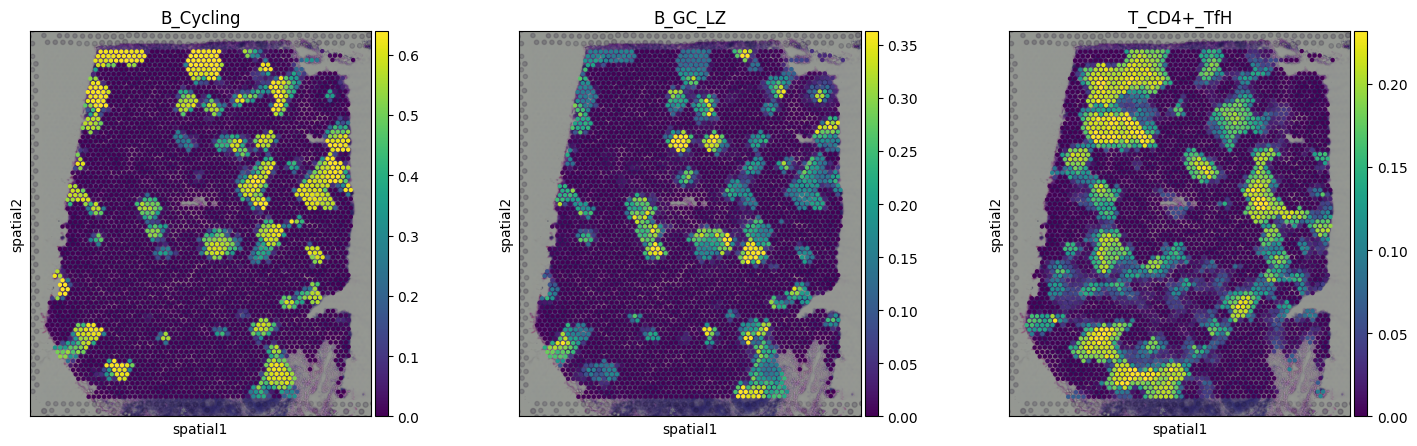

In [69]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [5, 5]}):

         sc.pl.spatial(adata, cmap='viridis',
                  # selected cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH'],#, 'T_CD8+_naive'],
                  ncols=5, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  show=True
                 )

For colormaps :
https://matplotlib.org/stable/tutorials/colors/colormaps.html 


# 11. Save the results

In [48]:
output_path = f"/sbgenomics/output-files/data/GraphST"
os.makedirs(output_path, exist_ok=True)

In [49]:
adata_integrate = f"{output_path}/ST_integrate_sc.h5ad"

In [50]:
adata.write(adata_integrate)
adata_integrate

'/sbgenomics/output-files/data/GraphST/ST_integrate_sc.h5ad'